## Database setup and initialization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import psycopg2
from psycopg2.extras import execute_values

# Load the Spotify dataset
data = pd.read_csv('spotify_dataset.csv', header=0)

# Basic data exploration
print(f"Dataset shape: {data.shape}")
print(data.head())

# Select relevant features for vector representation
song_features = data.columns

# Extract features and target variable
features = data[song_features].values
liked = data['liked'].values if 'liked' in data.columns else None

# Standardize features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Function to connect to PostgreSQL
def connect_to_postgres():
    conn = psycopg2.connect(
        host="localhost",
        database="music_vectors_db",
        user="postgres",
        password="postgres123"
    )
    return conn

# Create database and setup pgvector
def setup_database():
    # Connect to the database
    conn = connect_to_postgres()
    cursor = conn.cursor()

    # Execute init.sql file
    with open('init.sql', 'r') as init_file:
        cursor.execute(init_file.read())
    
    conn.commit()
    cursor.close()
    conn.close()
    
    print("Database setup complete")

# Insert data into pgvector database
def insert_data_to_pgvector():
    conn = connect_to_postgres()
    cursor = conn.cursor()
    
    # Clear existing data
    cursor.execute("TRUNCATE music_vectors")
    
    # Prepare data for insertion
    data_to_insert = [(f.tolist(),) for f in features_standardized]
    
    # Insert data in batches
    execute_values(
        cursor,
        "INSERT INTO music_vectors (features) VALUES %s",
        data_to_insert,
        template="(%s)"
    )
    
    conn.commit()
    cursor.close()
    conn.close()
    
    print(f"Inserted {len(data_to_insert)} records into pgvector database")


connect_to_postgres()
setup_database()
insert_data_to_pgvector()

Dataset shape: (195, 14)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


Database setup complete
Inserted 195 records into pgvector database


## PCA Visualization

PCA explained variance ratio: [0.31148714 0.13533981]
Total variance explained: 0.44682694930172223


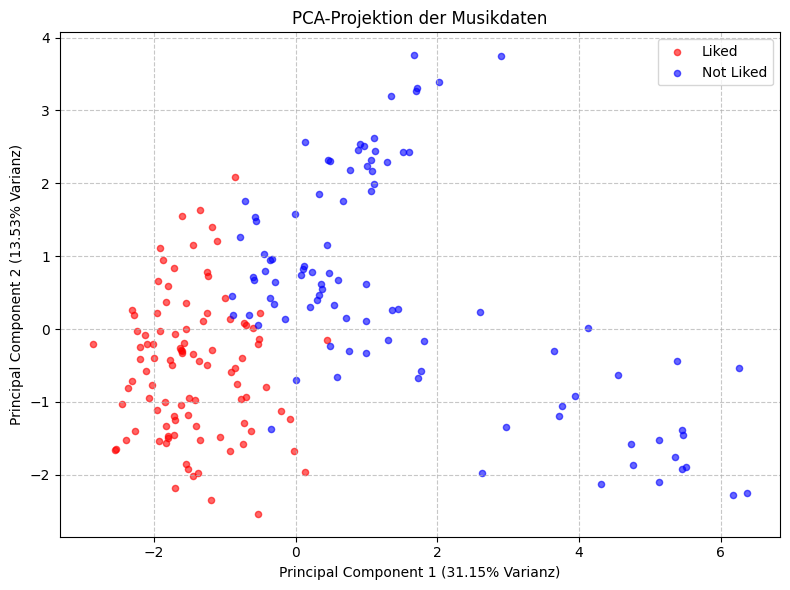

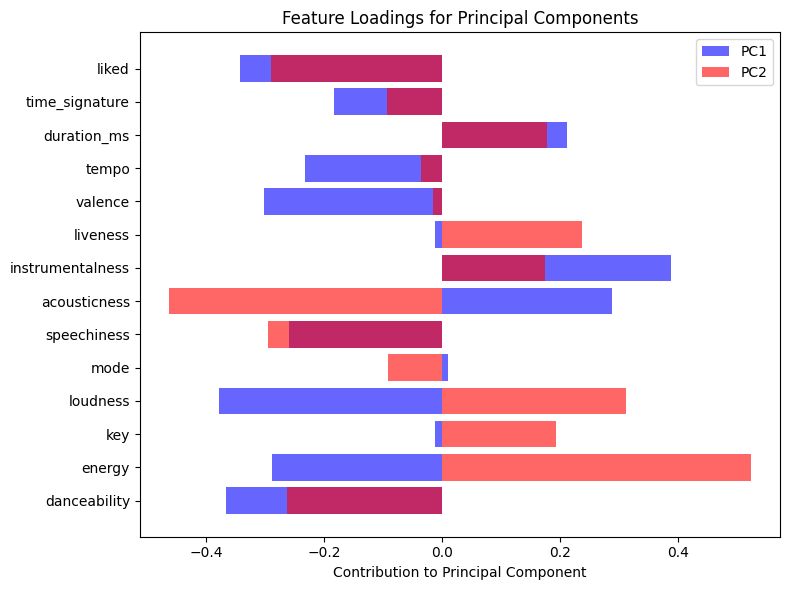

In [89]:
def perform_pca_analysis():
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_standardized)

    # Print how good PCA could split the data into the groups
    # 100% Explaind would mean that the data could be perfectly split into the groups, 
    # lower is worse
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)
    print("Total variance explained:", sum(pca.explained_variance_ratio_))

    # Basic PCA visualization
    plt.figure(figsize=(8, 6))
    
    # Use liked/disliked labels for coloring
    plt.scatter(pca_result[liked == 1, 0], pca_result[liked == 1, 1], 
                c='red', alpha=0.6, s=20, label='Liked')
    plt.scatter(pca_result[liked == 0, 0], pca_result[liked == 0, 1], 
                c='blue', alpha=0.6, s=20, label='Not Liked')
    plt.title('PCA-Projektion der Musikdaten')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} Varianz)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} Varianz)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_visualization.png', dpi=300)
    plt.show()


    # Analyze PCA loadings
    # This lets us examine how each feature contributes to the principal components    
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=song_features
    )
    # print("\nPCA Loadings:")
    # print(loadings)

    # Visualize loadings
    # A positive loading indicates that the feature is positively correlated with the principal component
    # A negative loading indicates that the feature is negatively correlated with the principal component
    plt.figure(figsize=(8, 6))
    plt.barh(song_features, loadings['PC1'], color='blue', alpha=0.6, label='PC1')
    plt.barh(song_features, loadings['PC2'], color='red', alpha=0.6, label='PC2')
    plt.xlabel('Contribution to Principal Component')
    plt.title('Feature Loadings for Principal Components')
    plt.legend()
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_loadings.png', dpi=300)
    plt.show()

    # # Plot grid of charts with all features highlighted
    # fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    # axes = axes.flatten()

    # for i, feature in enumerate(song_features):
    #     high_feature = features_standardized[:, i] > 1.0  # Standardized value > 1.0
    #     axes[i].scatter(pca_result[:, 0], pca_result[:, 1], c='lightgray', alpha=0.5, s=30)
    #     axes[i].scatter(pca_result[high_feature, 0], pca_result[high_feature, 1], s=50, alpha=0.8, label=f'High {feature}')
    #     axes[i].set_title(f'PCA Projection with High {feature.capitalize()}')
    #     axes[i].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
    #     axes[i].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
    #     axes[i].grid(True, linestyle='--', alpha=0.7)
    #     axes[i].legend()

    # plt.tight_layout()
    # plt.savefig('Documentation/resources/images/pca_highlighted_features_grid.png', dpi=300)
    # plt.show()
    
    return pca_result, pca

pca_result, pca = perform_pca_analysis()


 ## t-SNE Implementation and Visualization

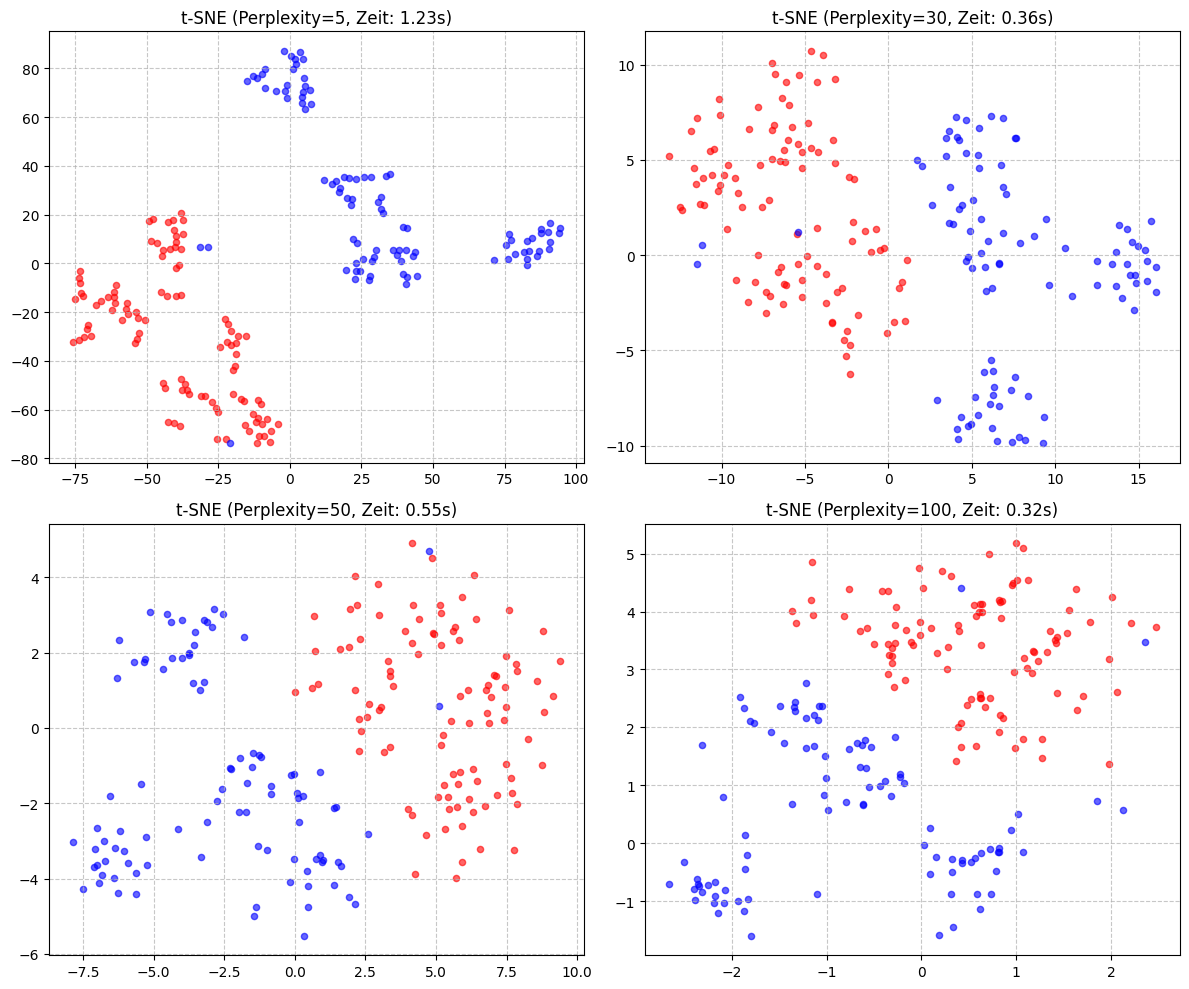

In [90]:
def perform_tsne_analysis():
    # t-SNE with different perplexity values
    perplexities = [5, 30, 50, 100]
    tsne_results = {}

    plt.figure(figsize=(12, 10))

    for i, perplexity in enumerate(perplexities):
        start_time = time.time()
        tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=5000, random_state=10)
        tsne_result = tsne.fit_transform(features_standardized)
        end_time = time.time()
        execution_time = end_time - start_time
        
        tsne_results[perplexity] = tsne_result
        
        plt.subplot(2, 2, i+1)
        plt.scatter(tsne_result[liked == 1, 0], tsne_result[liked == 1, 1], 
                    c='red', alpha=0.6, s=20, label='Liked')
        plt.scatter(tsne_result[liked == 0, 0], tsne_result[liked == 0, 1], 
                    c='blue', alpha=0.6, s=20, label='Not Liked')
        plt.title(f't-SNE (Perplexity={perplexity}, Zeit: {execution_time:.2f}s)')
        plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('Documentation/resources/images/tsne_perplexity_comparison.png', dpi=300)
    plt.show()
    
    # Use the best perplexity for further analysis
    best_perplexity = 30  # Choose the best perplexity based on visual inspection
    tsne_result = tsne_results[best_perplexity]

    # Plot grid of charts with all features highlighted
    # fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    # axes = axes.flatten()

    # for i, feature in enumerate(song_features):
    #     high_feature = features_standardized[:, i] > 1.0  # Standardized value > 1.0
    #     axes[i].scatter(tsne_result[:, 0], tsne_result[:, 1], c='lightgray', alpha=0.5, s=30)
    #     axes[i].scatter(tsne_result[high_feature, 0], tsne_result[high_feature, 1], s=50, alpha=0.8, label=f'High {feature}')
    #     axes[i].set_title(f't-SNE Projection with High {feature.capitalize()}')
    #     axes[i].set_xlabel('t-SNE Component 1')
    #     axes[i].set_ylabel('t-SNE Component 2')
    #     axes[i].grid(True, linestyle='--', alpha=0.7)
    #     axes[i].legend()

    # plt.tight_layout()
    # plt.savefig('Documentation/resources/images/tsne_highlighted_features_grid.png', dpi=300)
    # plt.show()
        
    return tsne_result, best_perplexity

_ = perform_tsne_analysis()

## PCA vs t-SNE Comparison

In [91]:
def compare_pca_tsne(pca_result, tsne_result, pca, best_perplexity):
    # Direct comparison between PCA and t-SNE
    plt.figure(figsize=(12, 6))
    
    # PCA plot
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[liked == 1, 0], pca_result[liked == 1, 1], 
                c='red', alpha=0.6, s=20, label='Liked')
    plt.scatter(pca_result[liked == 0, 0], pca_result[liked == 0, 1], 
                c='blue', alpha=0.6, s=20, label='Not Liked')
    plt.title('PCA-Projektion')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Varianz)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Varianz)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # t-SNE plot
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[liked == 1, 0], tsne_result[liked == 1, 1], 
                c='red', alpha=0.6, s=20, label='Liked')
    plt.scatter(tsne_result[liked == 0, 0], tsne_result[liked == 0, 1], 
                c='blue', alpha=0.6, s=20, label='Not Liked')    
    plt.title(f't-SNE-Projektion (Perplexity={best_perplexity})')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('Documentation/resources/images/pca_vs_tsne.png', dpi=300)
    plt.show()

# Main controll script


Running PCA analysis...
PCA explained variance ratio: [0.31148714 0.13533981]
Total variance explained: 0.44682694930172223


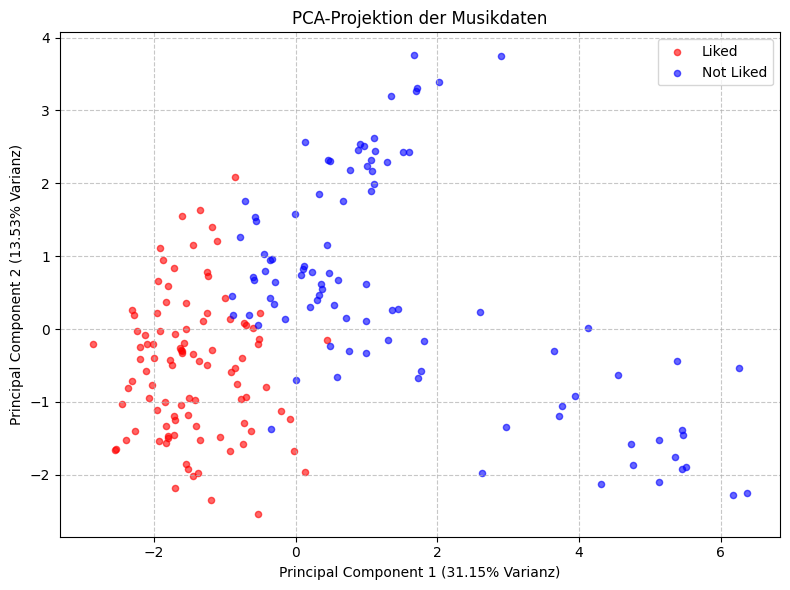

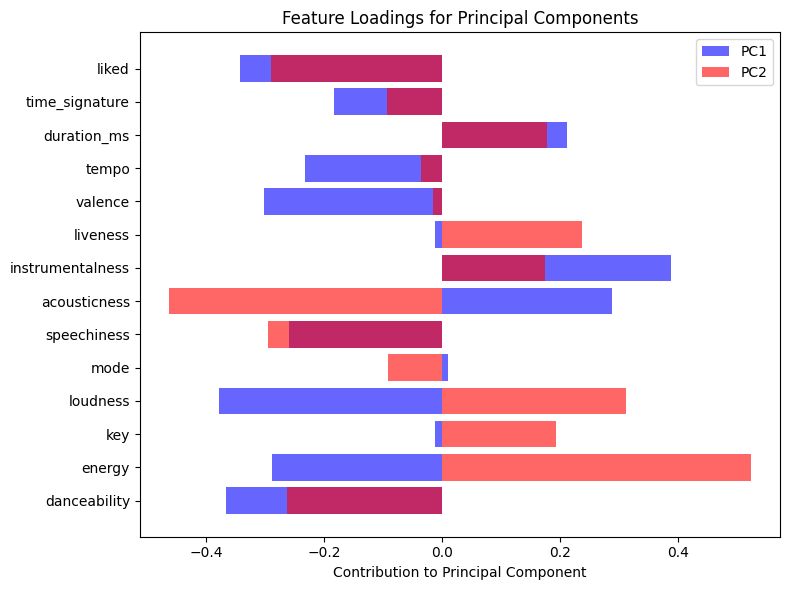


Running t-SNE analysis...


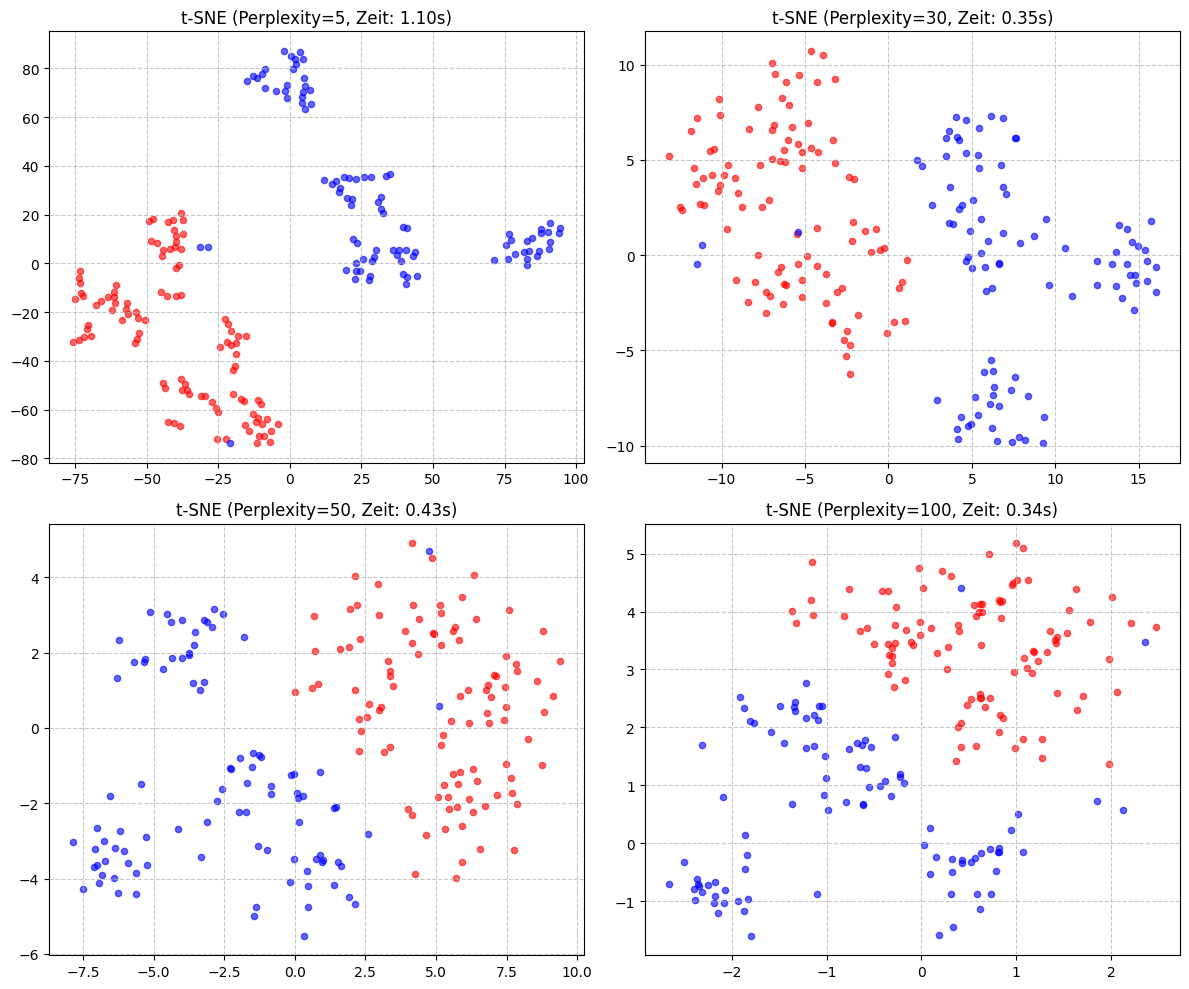


Comparing PCA and t-SNE results...


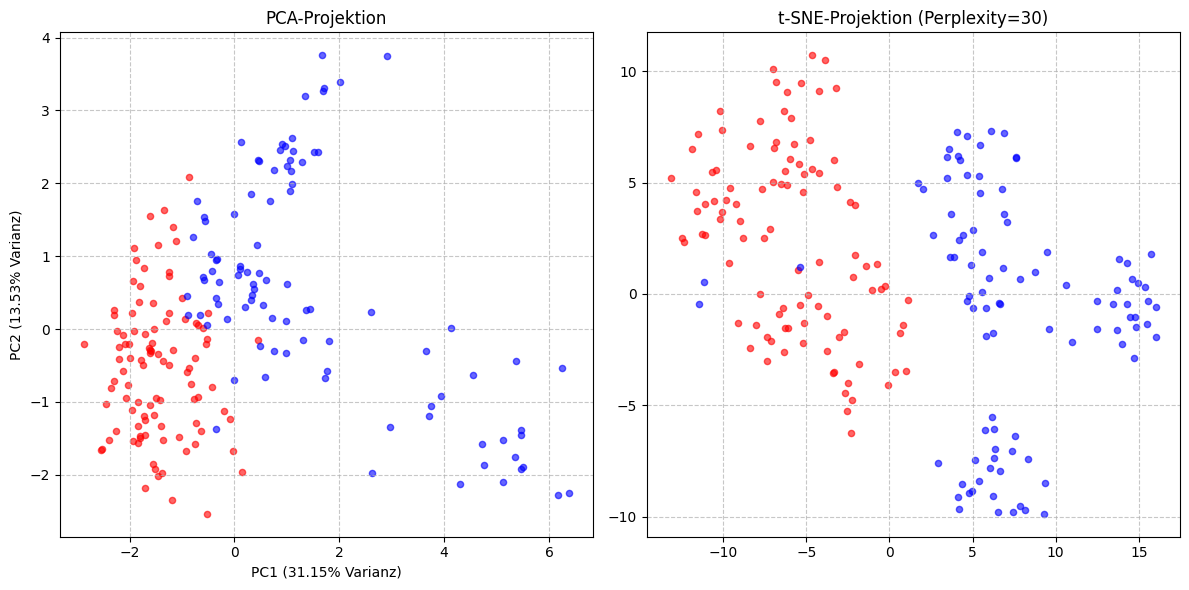


All analyses complete!


In [92]:
def main():
    print("\nRunning PCA analysis...")
    pca_result, pca = perform_pca_analysis()
    
    print("\nRunning t-SNE analysis...")
    tsne_result, best_perplexity = perform_tsne_analysis()
    
    print("\nComparing PCA and t-SNE results...")
    compare_pca_tsne(pca_result, tsne_result, pca, best_perplexity)
    
    print("\nAll analyses complete!")

# Run the main function
if __name__ == "__main__":
    main()
